In [2]:
! git clone https://github.com/neheller/kits19

fatal: destination path 'kits19' already exists and is not an empty directory.


In [3]:
  ! pip install -r kits19/requirements.txt    

In [4]:
cases_to_load = 30

In [5]:
from pathlib import Path
from shutil import move
import os
import sys
import time

from tqdm import tqdm
import requests
import numpy as np

imaging_url = "https://kits19.sfo2.digitaloceanspaces.com/"
imaging_name_tmplt = "master_{:05d}.nii.gz"
temp_f = Path("temp.tmp")


def get_destination(i):
    destination = Path("./kits19/data") / "case_{:05d}".format(i) / "imaging.nii.gz"
    if not destination.parent.exists():
        destination.parent.mkdir()
    return destination


def cleanup(bar, msg):
    bar.close()
    if temp_f.exists():
        temp_f.unlink()
    print(msg)
    sys.exit()


left_to_download = []
for i in range(cases_to_load):
    if not get_destination(i).exists():
        left_to_download = left_to_download + [i]


print("{} cases to download...".format(len(left_to_download)))
for i, cid in enumerate(left_to_download):
    print("Download {}/{}: ".format(
        i+1, len(left_to_download)
    ))
    destination = get_destination(cid)
    remote_name = imaging_name_tmplt.format(cid)
    uri = imaging_url + remote_name 

    chnksz = 1000
    tries = 0
    while True:
        try:
            tries = tries + 1
            response = requests.get(uri, stream=True)
            break
        except Exception as e:
            print("Failed to establish connection with server:\n")
            print(str(e) + "\n")
            if tries < 1000:
                print("Retrying in 30s")
                time.sleep(30)
            else:
                print("Max retries exceeded")
                sys.exit()

    try:
        with temp_f.open("wb") as f:
            bar = tqdm(
                unit="KB", 
                desc="case_{:05d}".format(cid), 
                total=int(
                    np.ceil(int(response.headers["content-length"])/chnksz)
                )
            )
            for pkg in response.iter_content(chunk_size=chnksz):
                f.write(pkg)
                bar.update(int(len(pkg)/chnksz))

            bar.close()
        move(str(temp_f), str(destination))
    except KeyboardInterrupt:
        cleanup(bar, "KeyboardInterrupt")
    except Exception as e:
        cleanup(bar, str(e))

30 cases to download...
Download 1/30: 


case_00000:   3%|▎         | 7471/225960 [00:24<11:44, 310.05KB/s]


KeyboardInterrupt


SystemExit: 

C:\Users\jlebs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from pathlib import Path

import nibabel as nib


def get_full_case_id(cid):
    try:
        cid = int(cid)
        case_id = "case_{:05d}".format(cid)
    except ValueError:
        case_id = cid

    return case_id


def get_case_path(cid):
    # Resolve location where data should be living
    data_path = Path("./kits19/") / "data"
    if not data_path.exists():
        raise IOError(
            "Data path, {}, could not be resolved".format(str(data_path))
        )

    # Get case_id from provided cid
    case_id = get_full_case_id(cid)

    # Make sure that case_id exists under the data_path
    case_path = data_path / case_id
    if not case_path.exists():
        raise ValueError(
            "Case could not be found \"{}\"".format(case_path.name)
        )

    return case_path


def load_volume(cid):
    case_path = get_case_path(cid)
    vol = nib.load(str(case_path / "imaging.nii.gz"))
    return vol


def load_segmentation(cid):
    case_path = get_case_path(cid)
    seg = nib.load(str(case_path / "segmentation.nii.gz"))
    return seg


def load_case(cid):
    vol = load_volume(cid)
    seg = load_segmentation(cid)
    return vol, seg

In [ ]:

import numpy as np
import nibabel as nib


def evaluate(gt, predictions):
    # Handle case of softmax output
    if len(predictions.shape) == 4:
        predictions = np.argmax(predictions, axis=-1)

    # Check predictions for type and dimensions
    if not isinstance(predictions, (np.ndarray, nib.Nifti1Image)):
        raise ValueError("Predictions must by a numpy array or Nifti1Image")
    if isinstance(predictions, nib.Nifti1Image):
        predictions = predictions.get_data()

    if not np.issubdtype(predictions.dtype, np.integer):
        predictions = np.round(predictions)
    predictions = predictions.astype(np.uint8)

    # Make sure shape agrees with case
    if not predictions.shape == gt.shape:
        raise ValueError(
            ("Predictions for case have shape {} "
            "which do not match ground truth shape of {}").format(
                predictions.shape, gt.shape
            )
        )

    try:
        # Compute tumor+kidney Dice
        tk_pd = np.greater(predictions, 0)
        tk_gt = np.greater(gt, 0)
        tk_dice = 2*np.logical_and(tk_pd, tk_gt).sum()/(
            tk_pd.sum() + tk_gt.sum()
        )
    except ZeroDivisionError:
        return 0.0, 0.0

    try:
        # Compute tumor Dice
        tu_pd = np.greater(predictions, 1)
        tu_gt = np.greater(gt, 1)
        tu_dice = 2*np.logical_and(tu_pd, tu_gt).sum()/(
            tu_pd.sum() + tu_gt.sum()
        )
    except ZeroDivisionError:
        return tk_dice, 0.0

    return tk_dice, tu_dice

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
import math

In [ ]:
def Kmeans(image,k):   
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

    centers = np.uint8(centers)

    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]

    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image,centers,labels

In [ ]:
def elbow(image, kmax):
  sse = []
  points = image.reshape((-1, 3))
  points = np.float32(points)
  for k in range(3, kmax+1):
    curr_sse = 0
    [segmented_image,centroids,pred_clusters]=Kmeans(points,k)
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse


In [ ]:
def segmentation(image,OptimalK,cluster):
    [segmented_image,c,labels]=Kmeans(image,OptimalK)
    masked_image = np.copy(image)
    masked_image = masked_image.reshape((-1, 3))
    cluster = cluster
    masked_image[labels == cluster] = [0, 0, 0]
    masked_image = masked_image.reshape(image.shape)
    return segmented_image, masked_image

In [ ]:
def calc_distance(x1,y1,a,b,c):
    d=abs((a*x1+b*y1+c))/(math.sqrt(a*a+b*b))
    return d

In [ ]:
def load(case=3, layer_no=161):
  case, segmentation = load_case(case)
  image_data = case.get_fdata()
  layer = image_data[layer_no]
  layer.shape
  img_layer = np.array(layer)
  pmax, pmin = np.max(img_layer), np.min(img_layer)
  im_volume = (img_layer - pmin)/max(pmax - pmin, 1e-3)
  im_volume = 255*im_volume
  return np.array(im_volume).astype('uint8'), segmentation.get_data()[layer_no]

In [ ]:
case, segmentation = load_case(1)
case.shape[0]

602

In [ ]:
def evaluate_case(case_id, layer):
  case, gt_seg = load(case_id, layer)
  plt.imshow(case, cmap='gray', vmin=0, vmax=255)

  image = cv2.cvtColor(case, cv2.COLOR_GRAY2RGB)
  ret,image = cv2.threshold(image,120,255,cv2.THRESH_TOZERO)
  plt.figure()
  plt.imshow(image, cmap='gray')
  kmax=10;
  sse=elbow(image,kmax)
  x=np.linspace(3,10,8)
  plt.figure()
  plt.plot(x,sse)
  plt.plot([x[0],x[7]],[sse[0],sse[7]],'ro-')
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('WSS')
  plt.title('Elbow method')


  a=sse[0]-sse[7]
  b=x[7]-x[0]
  c1=x[0]*sse[7]
  c2=x[7]*sse[0]
  c=c1-c2  
  distance=list()
  for i in range(8):
      distance.append(calc_distance(x[i],sse[i],a,b,c))

  fig=plt.figure()
  plt.plot(x,distance)
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('Distance between points')



  OptimalK=distance.index(max(distance))+3

  #plt.figure()
  #for i in range(1,OptimalK+1):
    #  [seg,masked]=segmentation(image,OptimalK,i)
      #plt.subplot(1,OptimalK,i)
      #plt.imshow(masked)
      #plt.axis('off')

  #plt.show()
  #plt.axis('off')

  masked_image = np.copy(image)
  masked_image = masked_image.reshape((-1, 3))
  [segmented_image,c,labels]=Kmeans(image,OptimalK)

  cluster = 0

  # for cluster in range(OptimalK):
  masked_image[labels != cluster] = [0, 255, 0]
  out_image = masked_image.reshape(image.shape)
  plt.imshow(out_image)
  plt.axis('off') 

  plt.show()
  return evaluate(gt_seg, labels.reshape(512,512))

In [ ]:
evaluate_case(3, 161)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


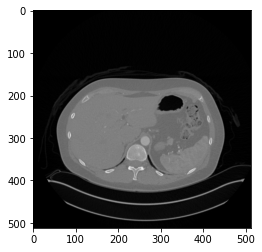

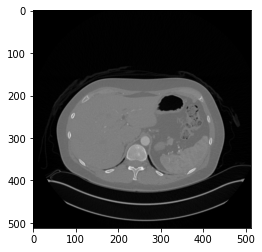

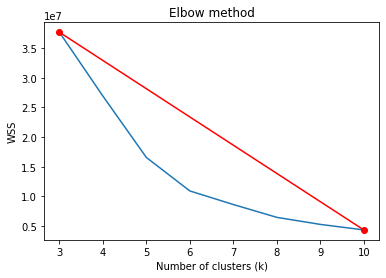

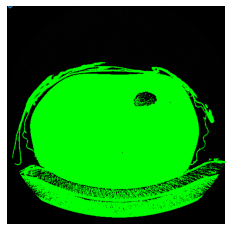

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


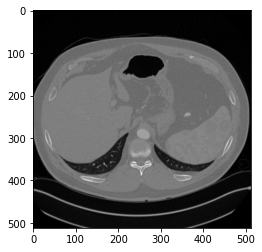

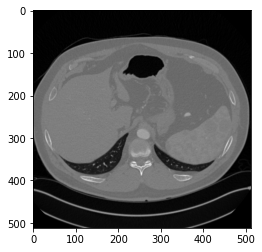

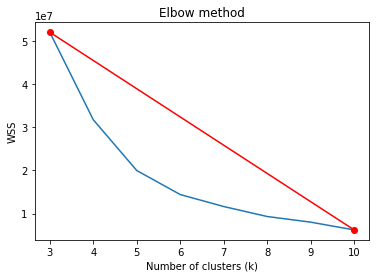

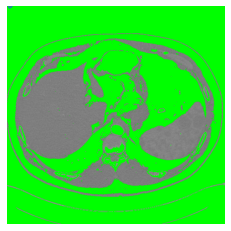

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


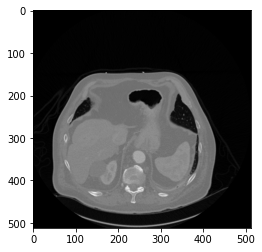

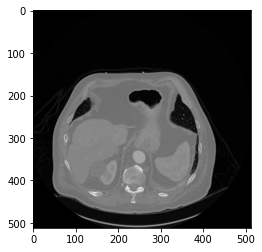

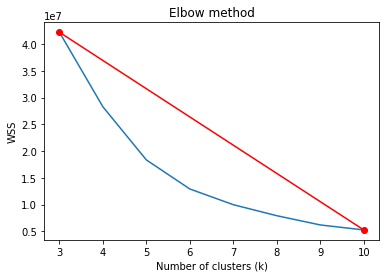

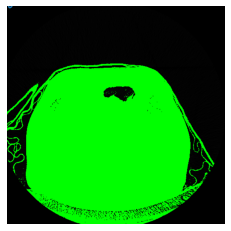

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


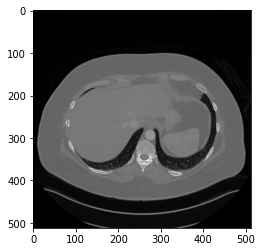

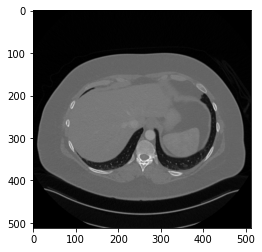

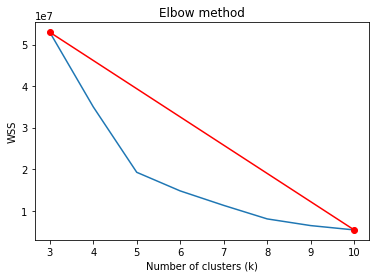

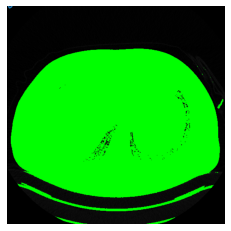

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


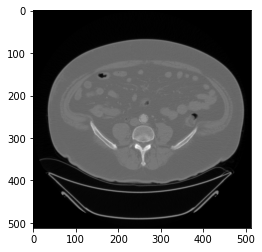

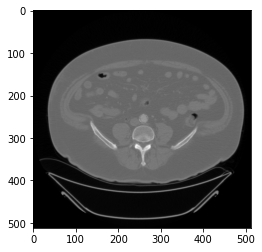

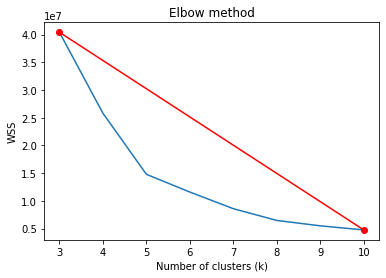

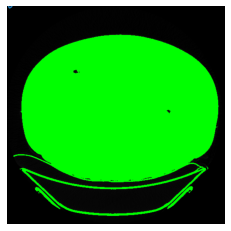

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


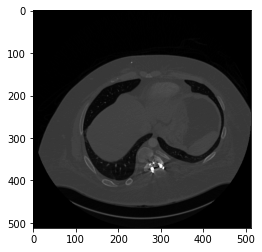

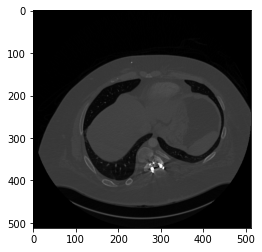

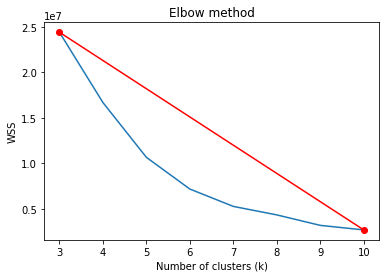

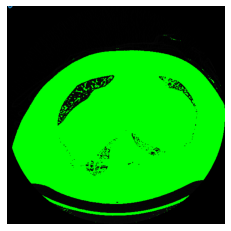

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


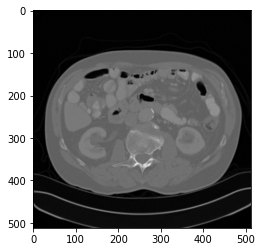

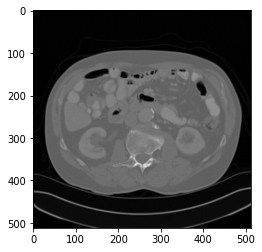

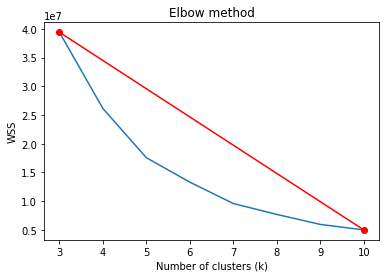

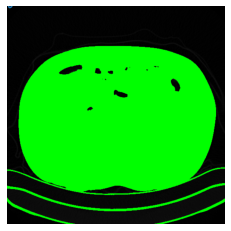

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


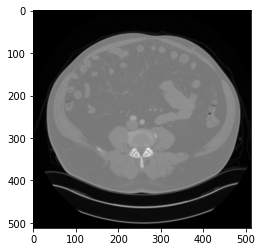

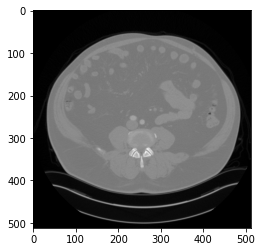

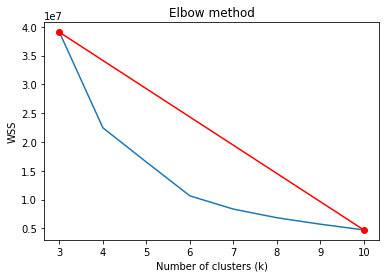

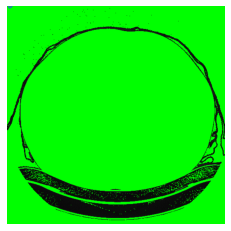

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


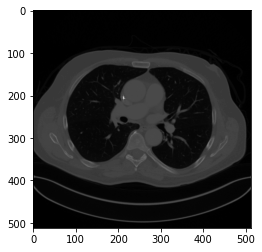

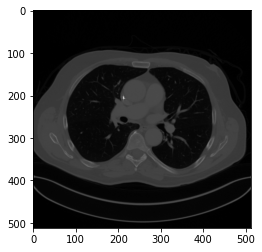

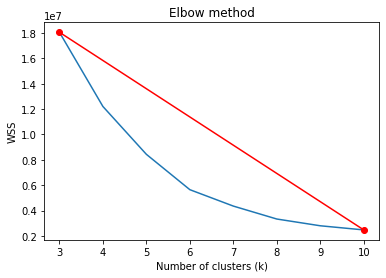

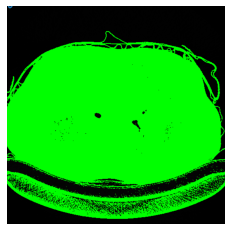

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


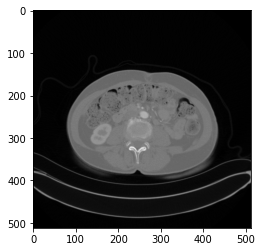

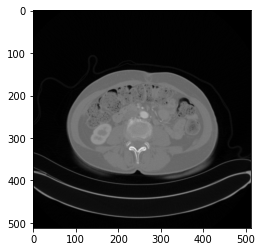

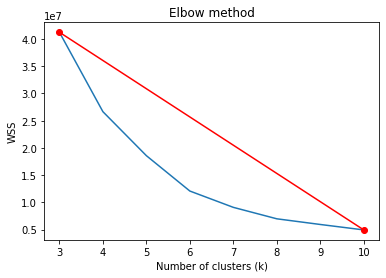

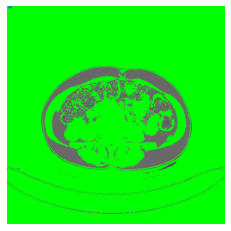

IndexError: ignored

In [ ]:
evaluation_results2 = []
for i in range(30):
    evaluation_results2.append(evaluate_case(i, 60))

In [ ]:
print(evaluation_results2)

[(0.0, 0.0), (0.0, 0.0), (0.04319108879824286, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.10166420294692671, 0.0), (0.0, 0.0), (0.0, 0.0), (0.01601178994820225, 0.0)]


In [ ]:
print(len(evaluation_results2))

10


In [ ]:
def results_2(evaluation_results, index):
  s1 = 0
  s2=0
  for result in evaluation_results:
    if result != (0.0, 0.0):
      s2+=1 
      s1 = s1 + result[index]
  mean = s1/s2
  #standard deviation
  sigma1 = 0
  for result in evaluation_results:
    if result != (0.0, 0.0):
      sigma1 = sigma1 + (result[index]-mean)**2
  sd = np.sqrt(sigma1/((s2-1)*s2))

  return mean, sd, s2

In [ ]:
def results(evaluation_results, index):
  # kidney segmentation evaluation
  #mean
  #index - 0 --> tumor+kidney; 1 --> tumor
  s1 = 0
  for result in evaluation_results:
    
    s1 = s1 + result[index]
  mean = s1/len(evaluation_results)
  #standard deviation
  sigma1 = 0
  for result in evaluation_results:
    sigma1 = sigma1 + (result[index]-mean)**2
  sd = np.sqrt(sigma1/((len(evaluation_results)-1)*len(evaluation_results)))

  return mean, sd 

In [ ]:
mean21, sd21 = results(evaluation_results2, index = 0)
print("Wyniki dla wykrycia guza i nerek")
print(mean21*100, "%")
print(sd21)

mean22, sd22 = results(evaluation_results2, index = 1)
print("Wyniki dla wykrycia guza")
print(mean22*100,"%")
print(sd22)

Wyniki dla wykrycia guza i nerek
1.608670816933718 %
0.010471992239886966
Wyniki dla wykrycia guza
0.0 %
0.0
